**Description :** This notebook will be mainly used for the Coursera capstone project.

**Author :** Tushar Jadhav

**Step 1**

Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import requests # library to handle requests
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium 

from folium import plugins
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans
from pandas.io.html import read_html
from collections import Counter
from datetime import date
from yellowbrick.cluster import KElbowVisualizer

c:\program files (x86)\python38-32\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


**Step 2**

Extract table from HTML page

We will use read_HTML function which returns list of tables read from HTML page i.e it returns list of dataframes.

In [2]:
# Read tables from HTML page
html_page = '01_Ntbk_Resources\WikiHTML\Canada_Wiki.html'
read_html_tables = read_html(html_page)
print ("Extracted {} tables from HTML page".format(len(read_html_tables)))

Extracted 3 tables from HTML page


There are 3 tables on given HTML page, Lets go through list and check where our required table is !

In [3]:
read_html_tables[0].head()

,Postal code,Borough,Neighborhood
0,M4N,Central Toronto,Lawrence Park
1,M5N,Central Toronto,Roselawn
2,M4P,Central Toronto,Davisville North
3,M5P,Central Toronto,Forest Hill North & West
4,M4R,Central Toronto,North Toronto West


As we can see, very first dataframe is our required table, so lets copy this into our new dataframe for further processing.

In [4]:
df_canada_zips = read_html_tables[0]

**Step 3**

Pre-process dataframe.

Lets use describe function on this dataframe.

In [5]:
df_canada_zips.describe()

,Postal code,Borough,Neighborhood
count,180,180,103
unique,180,11,98
top,M2C,Not assigned,Downsview
freq,1,77,4


We can have following observations from describe function output :
1. Column 'Postal code' have all unique values because :
    1. no. of 'count' is equal to no. of 'unique'
    2. 'freq' for 'top' is 1
2. So it is as per our assignment requirement, no need to process column 'Postal Code'
3. Column 'Borough' has 11 unique values out of which 'Not assigned' has highest count
4. As per assignment requirement, we need to drop these rows.

Lets find out index numbers with column "Borough" value equal to "Not assigned"

In [6]:
drop_index = df_canada_zips[df_canada_zips["Borough"] == "Not assigned"].index
df_canada_zips.drop(drop_index, inplace = True)

Lets check if there are any blank "Neighborhood"

In [7]:
df_canada_zips[df_canada_zips["Neighborhood"] == ""]

,Postal code,Borough,Neighborhood


As output is empty dataframe, "Neighborhood" column has no invalid values.
So our dataframe is ready for further processing. 
Lets check number of rows in dataframe.

In [8]:
print(f"There are {df_canada_zips.shape[0]} rows after pre-processing the dataframe.")

There are 103 rows after pre-processing the dataframe.


Lets read the 'Geospatial_Coordinates.csv' into dataframe which contains location information for each postal code.

In [9]:
df_canada_zips_coords = pd.read_csv("01_Ntbk_Resources\Geospatial_Coordinates.csv")
df_canada_zips_coords.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Now, we have to update our original dataframe with location information.

This can be done by using join function, it by default uses inner join.

In [10]:
df_canada_zips = df_canada_zips.join(df_canada_zips_coords.set_index('Postal Code'), on='Postal code')
df_canada_zips.head()

,Postal code,Borough,Neighborhood,Latitude,Longitude
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
1,M5N,Central Toronto,Roselawn,43.711695,-79.416936
2,M4P,Central Toronto,Davisville North,43.712751,-79.390197
3,M5P,Central Toronto,Forest Hill North & West,43.696948,-79.411307
4,M4R,Central Toronto,North Toronto West,43.715383,-79.405678


In [11]:
# create map of Canada using latitude and longitude values
map_canada = folium.Map(location=[df_canada_zips["Latitude"].mean(), df_canada_zips["Longitude"].mean()], zoom_start=11)

canada_zips_cluster = plugins.MarkerCluster()

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label, in zip(df_canada_zips['Latitude'], df_canada_zips['Longitude'], df_canada_zips['Postal code']):
    
    canada_zips_cluster.add_child  (
                                    folium.Marker  (
                                        location=[lat, lng],
                                        icon=None,
                                        popup=label,
                                                    )
                                    ).add_to(map_canada)  
    
map_canada

Lets limit our data to city of 'Toronta' for better analysis.

In [12]:
df_toronto_zips = df_canada_zips[df_canada_zips["Borough"].str.contains('Toronto')]
df_toronto_zips.reset_index(inplace=True)
df_toronto_zips.head()

,index,Postal code,Borough,Neighborhood,Latitude,Longitude
0,0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
1,1,M5N,Central Toronto,Roselawn,43.711695,-79.416936
2,2,M4P,Central Toronto,Davisville North,43.712751,-79.390197
3,3,M5P,Central Toronto,Forest Hill North & West,43.696948,-79.411307
4,4,M4R,Central Toronto,North Toronto West,43.715383,-79.405678


Lets visualize these neighbourhoods on map.

In [13]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[df_toronto_zips["Latitude"].mean(), df_toronto_zips["Longitude"].mean()], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df_toronto_zips["Latitude"], df_toronto_zips["Longitude"], df_toronto_zips['Neighborhood']):
    folium.CircleMarker(
        location = [lat, lng],
        radius=5,
        popup=label,
        fill=True
        ).add_to(map_toronto)  
    
map_toronto

In [14]:
CLIENT_ID = 'KHBCFH4FM1WHVXCXZ5XQWLRTSOTVNKYALTNG504ORN50SHOC' # Foursquare ID
CLIENT_SECRET = 'X5M0FQ2AWS32VG0FY4JSCOFK54R12J4NFTLCTKV2IZ0RTP4J' # Foursquare Secret
VERSION = date.today().strftime("%Y%m%d") # Foursquare API version
RADIUS = 1000 # define radius
LIMIT = 100 # limit of number of venues returned by Foursquare API
NO_OF_VENUES = 10 # no of venues to extract

Lets define a function that will extract sorted venues from response received from URL request.

In [15]:
def venues_extractor (client_id, client_secret, version, radius, limit, lat, long) :
    
    venues_category = []
    list_sorted_venues_category = []
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            client_id, 
            client_secret, 
            version, 
            lat, 
            long, 
            radius, 
            limit)
    
    url_response = requests.get(url).json()     

    if url_response['response']['totalResults'] > 0 :
        for venue_index in range(0,len(url_response['response']['groups'][0]['items'])):
            venues_category.append(url_response['response']['groups'][0]['items'][venue_index]['venue']['categories'][0]['name'])
    
    dict_venues_category = dict(Counter(venues_category))
    sorted_venues_category = sorted(dict_venues_category.items() , key = lambda lambda1 : lambda1[1] , reverse = True)
    dict_sorted_venues_category = dict(sorted_venues_category)
    dict_sorted_venues_category.pop("Neighborhood", None)  
    
    return dict_sorted_venues_category

In [16]:
# Lets list out column names
col_list = [str(f"{u+1}{i} Most Common Venue") for u,i in enumerate(['st', 'nd', 'rd'])] + [str(f"{i}th Most Common Venue") for i in range(4,11)]
df_toronto_most_common = pd.DataFrame(columns = col_list)
df_toronto_venues = pd.DataFrame()

# call the defined function and extract the venues
for lat, long in zip(df_toronto_zips["Latitude"], df_toronto_zips["Longitude"]) :
    dict_toronto_venues_category = venues_extractor(CLIENT_ID,
                                       CLIENT_SECRET,
                                       VERSION,
                                       RADIUS,
                                       LIMIT,                                                                    
                                       lat,
                                       long
                                       )
    
    #######################
    # develope a dataframe that contains all the venues for given neighbourhood
    
    df_temp = pd.DataFrame(dict_toronto_venues_category, index = [len(df_toronto_venues)])
    df_toronto_venues = pd.concat([df_toronto_venues, df_temp]).fillna(0)  
    
    #######################
    # develope a dataframe that contains top venues for given neighbourhood
    
    list_toronto_venues_category = list(dict_toronto_venues_category)
    
    if len(list_toronto_venues_category) >= NO_OF_VENUES :
        list_toronto_most_common = list_toronto_venues_category[:NO_OF_VENUES]
    else :
        list_toronto_most_common = list_toronto_venues_category + ["" for index in range(0, NO_OF_VENUES-len(list_toronto_venues_category))]
    
    df_toronto_most_common.loc[len(df_toronto_most_common), : ] = list_toronto_most_common

Lets take a look at how our dataframe which contains top venues for neighbourhoods.

In [17]:
df_toronto_neighbors_with_most_common_venues = df_toronto_zips.join(df_toronto_most_common).drop(["index"], axis = 1)
df_toronto_neighbors_with_most_common_venues

,Postal code,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,Café,Park,Gym / Fitness Center,Coffee Shop,Bookstore,Trail,College Quad,College Gym,,
1,M5N,Central Toronto,Roselawn,43.711695,-79.416936,Sushi Restaurant,Café,Coffee Shop,Italian Restaurant,Bank,Pharmacy,Gym,Gastropub,Bakery,Japanese Restaurant
2,M4P,Central Toronto,Davisville North,43.712751,-79.390197,Coffee Shop,Italian Restaurant,Café,Restaurant,Pizza Place,Dessert Shop,Sushi Restaurant,Gym,Fast Food Restaurant,Food & Drink Shop
3,M5P,Central Toronto,Forest Hill North & West,43.696948,-79.411307,Coffee Shop,Café,Bank,Trail,Italian Restaurant,Sushi Restaurant,Burger Joint,Park,Japanese Restaurant,Gym / Fitness Center
4,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,Coffee Shop,Italian Restaurant,Café,Diner,Restaurant,Park,Mexican Restaurant,Sporting Goods Shop,Clothing Store,Skating Rink
5,M5R,Central Toronto,The Annex / North Midtown / Yorkville,43.672710,-79.405678,Café,Vegetarian / Vegan Restaurant,Coffee Shop,Italian Restaurant,Bakery,Grocery Store,Pizza Place,Museum,Restaurant,Gym
6,M4S,Central Toronto,Davisville,43.704324,-79.388790,Italian Restaurant,Coffee Shop,Sushi Restaurant,Café,Pizza Place,Dessert Shop,Indian Restaurant,Gym,Restaurant,Middle Eastern Restaurant
7,M4T,Central Toronto,Moore Park / Summerhill East,43.689574,-79.383160,Grocery Store,Italian Restaurant,Park,Coffee Shop,Restaurant,Thai Restaurant,Gym,Sandwich Place,Café,Bagel Shop
8,M4V,Central Toronto,Summerhill West / Rathnelly / South Hill / For...,43.686412,-79.400049,Coffee Shop,Sushi Restaurant,Italian Restaurant,Thai Restaurant,Restaurant,Park,Grocery Store,Gym / Fitness Center,Liquor Store,Bagel Shop
9,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636,Coffee Shop,Restaurant,Café,Pub,Theater,Diner,Bakery,Park,Breakfast Spot,Italian Restaurant


Also, take a look at dataframe with all the venues for neighbourhoods.

In [18]:
df_toronto_neighbors_with_all_venues = df_toronto_zips.join(df_toronto_venues).drop(["index"], axis = 1)
df_toronto_neighbors_with_all_venues

,Postal code,Borough,Neighborhood,Latitude,Longitude,Café,Park,Gym / Fitness Center,Coffee Shop,Bookstore,...,Storage Facility,Amphitheater,Zoo,Other Great Outdoors,Elementary School,Intersection,Smoothie Shop,Supplement Shop,Pilates Studio,Market
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,2.0,1.0,1.0,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,M5N,Central Toronto,Roselawn,43.711695,-79.416936,2.0,0.0,0.0,2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,M4P,Central Toronto,Davisville North,43.712751,-79.390197,4.0,1.0,0.0,13,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,M5P,Central Toronto,Forest Hill North & West,43.696948,-79.411307,3.0,2.0,2.0,4,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,2.0,2.0,0.0,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,M5R,Central Toronto,The Annex / North Midtown / Yorkville,43.672710,-79.405678,6.0,1.0,0.0,4,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,M4S,Central Toronto,Davisville,43.704324,-79.388790,4.0,1.0,0.0,8,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,M4T,Central Toronto,Moore Park / Summerhill East,43.689574,-79.383160,2.0,4.0,1.0,4,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,M4V,Central Toronto,Summerhill West / Rathnelly / South Hill / For...,43.686412,-79.400049,2.0,3.0,3.0,7,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636,4.0,3.0,2.0,15,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Before clustering the neighbourhoods we must identify the columns required for clustering and normalize the dataframe.
Here, we've to normalize the dataframe by row.

In [19]:
# Lets list out column names required for clustering
reqd_df_cols_for_clustering = [0] + [i for i in range(5,df_toronto_neighbors_with_all_venues.shape[1])]

df_toronto_for_clustering = df_toronto_neighbors_with_all_venues.iloc[:,reqd_df_cols_for_clustering]
df_toronto_for_clustering

,Postal code,Café,Park,Gym / Fitness Center,Coffee Shop,Bookstore,Trail,College Quad,College Gym,Sushi Restaurant,...,Storage Facility,Amphitheater,Zoo,Other Great Outdoors,Elementary School,Intersection,Smoothie Shop,Supplement Shop,Pilates Studio,Market
0,M4N,2.0,1.0,1.0,1,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,M5N,2.0,0.0,0.0,2,0.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,M4P,4.0,1.0,0.0,13,2.0,0.0,0.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,M5P,3.0,2.0,2.0,4,1.0,2.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,M4R,2.0,2.0,0.0,4,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,M5R,6.0,1.0,0.0,4,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,M4S,4.0,1.0,0.0,8,2.0,0.0,0.0,0.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,M4T,2.0,4.0,1.0,4,0.0,1.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,M4V,2.0,3.0,3.0,7,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,M5A,4.0,3.0,2.0,15,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# normalize the dataframe by row
df_toronto_normalized_for_clustering = df_toronto_for_clustering.copy()
df_toronto_normalized_for_clustering.loc[:,1:] = df_toronto_normalized_for_clustering.iloc[:,1:].div(df_toronto_normalized_for_clustering.iloc[:,1:].sum(axis=1), axis=0)
df_toronto_normalized_for_clustering

,Postal code,Café,Park,Gym / Fitness Center,Coffee Shop,Bookstore,Trail,College Quad,College Gym,Sushi Restaurant,...,Storage Facility,Amphitheater,Zoo,Other Great Outdoors,Elementary School,Intersection,Smoothie Shop,Supplement Shop,Pilates Studio,Market
0,M4N,0.222222,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.000000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000
1,M5N,0.080000,0.000000,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.120000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000
2,M4P,0.040000,0.010000,0.000000,0.130000,0.020000,0.000000,0.000000,0.000000,0.030000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000
3,M5P,0.063830,0.042553,0.042553,0.085106,0.021277,0.042553,0.000000,0.000000,0.042553,...,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000
4,M4R,0.045455,0.045455,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.022727,...,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000
5,M5R,0.060000,0.010000,0.000000,0.040000,0.020000,0.000000,0.000000,0.000000,0.010000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000
6,M4S,0.040000,0.010000,0.000000,0.080000,0.020000,0.000000,0.000000,0.000000,0.060000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000
7,M4T,0.031250,0.062500,0.015625,0.062500,0.000000,0.015625,0.000000,0.000000,0.031250,...,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000
8,M4V,0.026316,0.039474,0.039474,0.092105,0.000000,0.000000,0.000000,0.000000,0.065789,...,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000
9,M5A,0.040000,0.030000,0.020000,0.150000,0.000000,0.000000,0.000000,0.000000,0.020000,...,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.000000


Column 'Postal code' should be dropped for clustering.

In [21]:
df_toronto_normalized_for_clustering = df_toronto_normalized_for_clustering.drop("Postal code", axis = 1)

KMeans clustering requires value of K to be defined by user, we'll find out best value of K using KElbowVisualizer

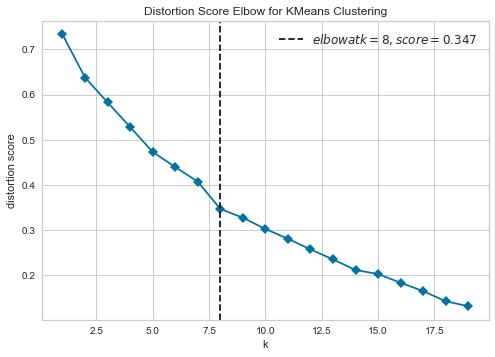

In [22]:
# instantiate the clustering model and visualizer, we'll use fixed random state to make randomness deterministic.
model = KMeans(random_state=0)
visualizer = KElbowVisualizer(model, k=(1,20), timings=False)

best_k = visualizer.fit(df_toronto_normalized_for_clustering.values).elbow_value_  # fit the data to the visualizer and get elbow value
visualizer.show() # finalize and render the figure

In [23]:
kclusters = best_k

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_toronto_normalized_for_clustering.values)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([7, 0, 2, 2, 2, 6, 2, 2, 2, 2])

Now lets add these clustered labels to our dataframe.

In [24]:
df_toronto_clustered = df_toronto_neighbors_with_all_venues.copy()
df_toronto_clustered.insert(5, 'Cluster Label', kmeans.labels_)
df_toronto_clustered

,Postal code,Borough,Neighborhood,Latitude,Longitude,Cluster Label,Café,Park,Gym / Fitness Center,Coffee Shop,...,Storage Facility,Amphitheater,Zoo,Other Great Outdoors,Elementary School,Intersection,Smoothie Shop,Supplement Shop,Pilates Studio,Market
0,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,7,2.0,1.0,1.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,M5N,Central Toronto,Roselawn,43.711695,-79.416936,0,2.0,0.0,0.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,M4P,Central Toronto,Davisville North,43.712751,-79.390197,2,4.0,1.0,0.0,13,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,M5P,Central Toronto,Forest Hill North & West,43.696948,-79.411307,2,3.0,2.0,2.0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,2,2.0,2.0,0.0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,M5R,Central Toronto,The Annex / North Midtown / Yorkville,43.672710,-79.405678,6,6.0,1.0,0.0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,M4S,Central Toronto,Davisville,43.704324,-79.388790,2,4.0,1.0,0.0,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,M4T,Central Toronto,Moore Park / Summerhill East,43.689574,-79.383160,2,2.0,4.0,1.0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,M4V,Central Toronto,Summerhill West / Rathnelly / South Hill / For...,43.686412,-79.400049,2,2.0,3.0,3.0,7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,M5A,Downtown Toronto,Regent Park / Harbourfront,43.654260,-79.360636,2,4.0,3.0,2.0,15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Lets visualize the clustering on folium map.

In [25]:
# create map
map_toronto_clusters = folium.Map(location=[df_toronto_clustered["Latitude"].mean(), df_toronto_clustered["Longitude"].mean()], zoom_start=11)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
colors_array = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_toronto_clustered['Latitude'], df_toronto_clustered['Longitude'], df_toronto_clustered['Neighborhood'], df_toronto_clustered['Cluster Label']):
    label = folium.Popup(str(poi) + '\n - \n Cluster' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors_array[cluster-1],
        fill=True,
        fill_color=colors_array[cluster-1],
        fill_opacity=1).add_to(map_toronto_clusters)
       
map_toronto_clusters